# Prepare
This notebook prepares data for LSSxCMB 

In [1]:
import fitsio as ft
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from astropy.table import Table
import sys
sys.path.insert(0, '/users/PHS0336/medirz90/github/LSSutils')
from lssutils.utils import hpix2radec

In [2]:
%matplotlib inline

## New Fracgood

In [3]:
fracgood = hp.read_map('/fs/ess/PHS0336/data/elgmask/fracgood_hp_1024.fits')

/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:351: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [4]:
is_seen = fracgood > 0
fracgood[~is_seen] = hp.UNSEEN

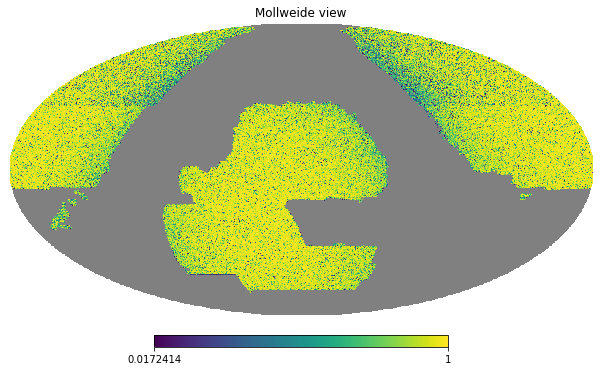

In [5]:
hp.mollview(fracgood)

In [6]:
fracgood[is_seen].max()

1.0

In [18]:
npix = 12*1024*1024
cnt = np.zeros(npix)
frc = np.zeros(npix)


for r in ['bmzls', 'ndecals', 'sdecals']:
    data = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v8/nelg_features_{r}_1024.fits')
    frac_r = fracgood[data['hpix']]
    ra, dec = hpix2radec(1024, data['hpix'])
    is_bad = (frac_r==hp.UNSEEN) | (dec < -19) # get rid of islands
    
    data_good = data[~is_bad]
    data_good['fracgood'] = frac_r[~is_bad]
    
    #ft.write(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v9/nelg_features_{r}_1024.fits', 
    #         data_good, clobber=True)
    
    
    frc[data_good['hpix']] += data_good['fracgood']
    cnt[data_good['hpix']] += 1.0
    print(r, (data_good['fracgood']==hp.UNSEEN).sum())
    
frc = frc/cnt    
frc[cnt<0.5] = hp.UNSEEN
hp.write_map('/fs/ess/PHS0336/data/tanveer/dr9/v9/elg_fracgood_hp1024.fits', frc, fits_IDL=False, overwrite=True)

bmzls 0
ndecals 0
sdecals 0


/tmp/slurmtmp.27387500/ipykernel_4660/2896242966.py:23: RuntimeWarning: invalid value encountered in true_divide
  frc = frc/cnt


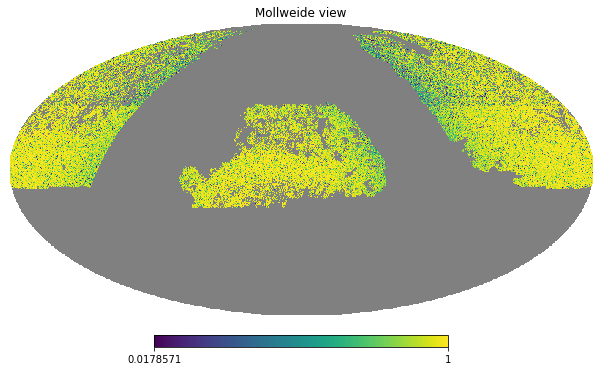

In [19]:
hp.mollview(frc)

In [16]:
d = hp.read_map('/fs/ess/PHS0336/data/tanveer/dr9/v9/elg_fracgood_hp1024.fits')

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:351: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


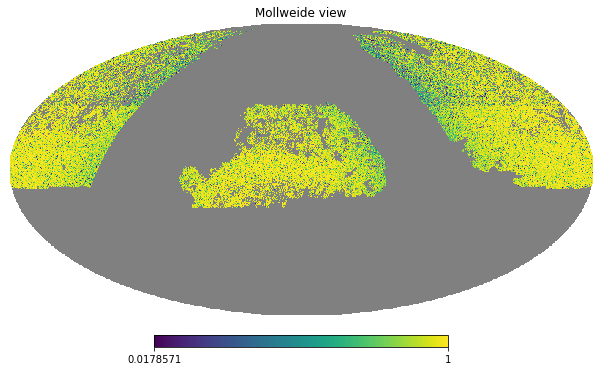

In [17]:
hp.mollview(d)

In [18]:
d = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v9/nelg_features_sdecals_1024.fits')

In [19]:
ra,dec = hpix2radec(1024, d['hpix'])

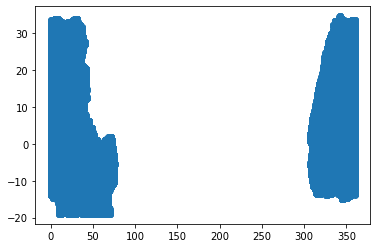

In [20]:
plt.scatter(ra, dec)

# New dust maps
Rongpu's R-G stellar redding based, etc

In [3]:
sag = np.load('/fs/ess/PHS0336/data/tanveer/sag_stream_smoothed_10deg.npy')
dust = np.load('/fs/ess/PHS0336/data/tanveer/dustmaps_full_dict.pickle', allow_pickle=True)

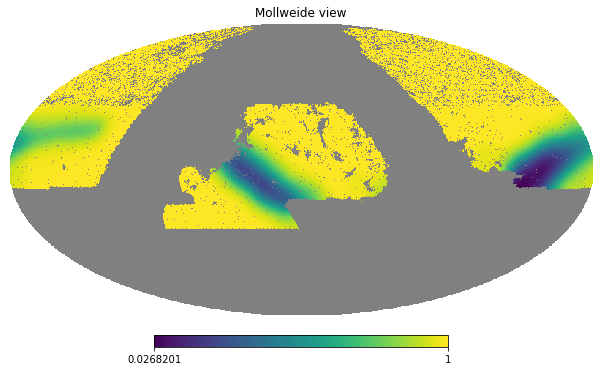

In [4]:
hp.mollview(sag)

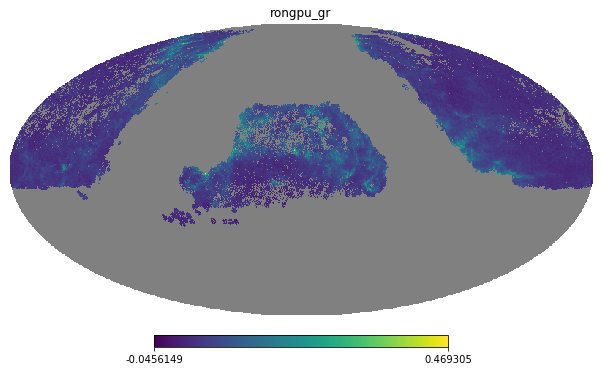

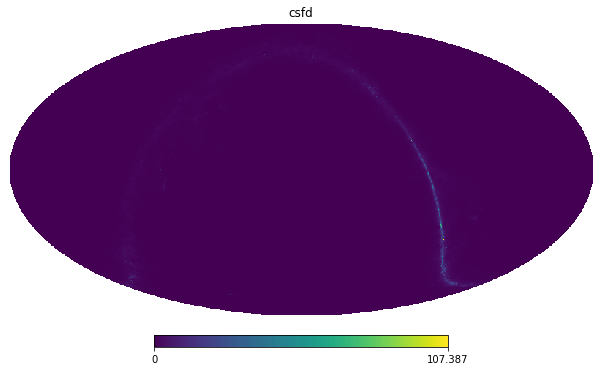

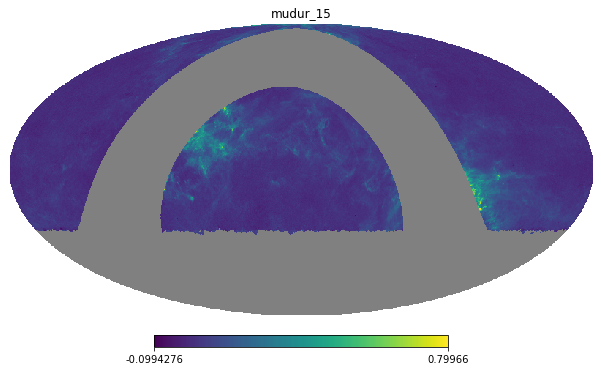

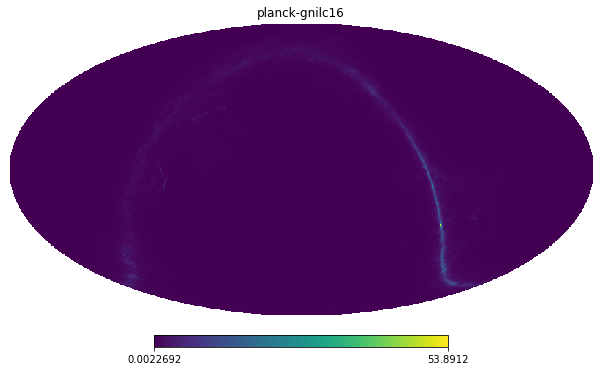

In [5]:
for name in ['rongpu_gr' , 'csfd', 'mudur_15', 'planck-gnilc16']:
    hp.mollview(dust[name], title=name)

In [6]:
for r in ['bmzls', 'ndecals', 'sdecals']:

    data = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v6/nelg_features_{r}_1024.fits')
    features = []
    for i, col_i in enumerate(data['features'].T):
        features.append(col_i)
    for col_i in [sag, dust['rongpu_gr'], dust['csfd'], dust['mudur_15'], dust['planck-gnilc16']]:
        features.append(col_i[data['hpix']])
    features = np.array(features).T

    is_good  = (np.isnan(features).sum(axis=1) == 0) 
    is_good &= ((features == hp.UNSEEN).sum(axis=1)==0)
    
    meta_data = Table(dict(hpix=data['hpix'][is_good],
                     fracgood=data['fracgood'][is_good],
                     features=features[is_good],
                     label=data['label'][is_good]))

    print(r, len(meta_data)/len(data))
    meta_data.write(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v8/nelg_features_{r}_1024.fits', 
                    format='fits', overwrite=True)

bmzls 0.8411656609471144
ndecals 0.8972968581204092
sdecals 0.6989773656584025


In [7]:
meta_data['features'].shape

(1070098, 18)

In [8]:
ls /fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v8/

nelg_features_bmzls_1024.fits    nelg_features_sdecals_1024.fits
nelg_features_ndecals_1024.fits


In [5]:
npix = 12*1024*1024
cnt = np.zeros(npix)
frc = np.zeros(npix)

for r in ['bmzls', 'ndecals', 'sdecals']:
    d = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v8/nelg_features_{r}_1024.fits')
    
    frc[d['hpix']] += d['fracgood']
    cnt[d['hpix']] += 1.0

(array([0.02870833, 0.10047914, 0.59569776, 1.29187466, 1.9736974 ,
        1.55742667, 1.59331208, 0.68899982, 0.3086145 , 0.05741665]),
 array([0.30501839, 0.42702575, 0.54903311, 0.67104047, 0.79304783,
        0.91505518, 1.03706254, 1.1590699 , 1.28107726, 1.40308461,
        1.52509197]),
 <a list of 10 Patch objects>)

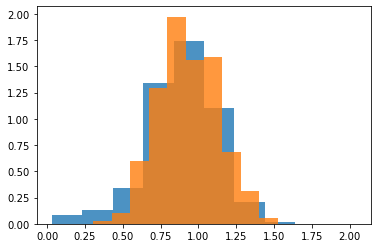

In [20]:
plt.hist(frc[cnt>0], density=True, alpha=0.8)
plt.hist(frc[cnt>1], density=True, alpha=0.8)

In [21]:
(cnt>1).sum()

1142

In [25]:
frc[cnt<0.5] = hp.UNSEEN

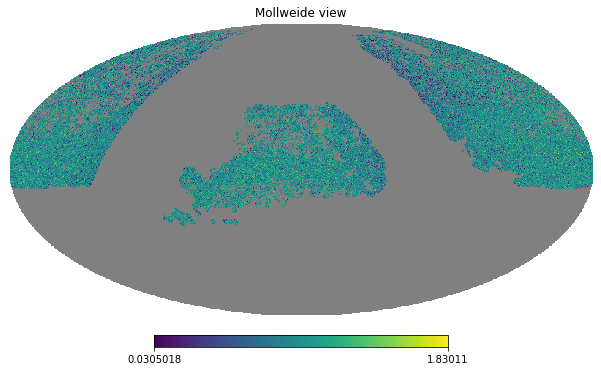

In [26]:
hp.mollview(frc)

In [27]:
hp.write_map('/fs/ess/PHS0336/data/tanveer/dr9/v8/elg_fracgood_hp1024.fits', frc, fits_IDL=False)

/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:184: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  warnings.warn(


## Mudur 15', 6', Sag Stream, Lenz

In [4]:
lens = ft.read('/fs/ess/PHS0336/data/templates/ebv_lhd.hpx.fits')['EBV']
r = hp.Rotator(coord=['G', 'C'])
dust_lens = r.rotate_map_pixel(lens)

mud15 = np.load('/fs/ess/PHS0336/data/tanveer/Mudur_fw15_NSIDE1024_eq_ELG_mask.npy')
mud6 = np.load('/fs/ess/PHS0336/data/tanveer/Mudur_fw6-1_NSIDE1024_eq_ELG_mask.npy')
sagm = np.load('/fs/ess/PHS0336/data/tanveer/SgrStream_Ramos_NSIDE1024_eq_ELG_mask.npy')
hpix_sag = np.argwhere(sagm > 0.5).flatten()

In [5]:
for r in ['bmzls', 'ndecals', 'sdecals']:

    data = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v6/nelg_features_{r}_1024.fits')
    features = []
    for i, col_i in enumerate(data['features'].T):
        features.append(col_i)
    for col_i in [dust_lens[data['hpix']], mud15[data['hpix']], mud6[data['hpix']]]:
        features.append(col_i)
    features = np.array(features).T

    is_good  = (np.isnan(features).sum(axis=1) == 0) 
    is_good &= ((features == hp.UNSEEN).sum(axis=1)==0)
    is_good &= np.in1d(data['hpix'], hpix_sag)

    meta_data = Table(dict(hpix=data['hpix'][is_good],
                     fracgood=data['fracgood'][is_good],
                     features=features[is_good],
                     label=data['label'][is_good]))

    print(r, len(meta_data)/len(data))
    meta_data.write(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v7/nelg_features_{r}_1024.fits', 
                    format='fits', overwrite=True)

bmzls 0.813398969767272
ndecals 0.6441915400054767
sdecals 0.45737934926594503


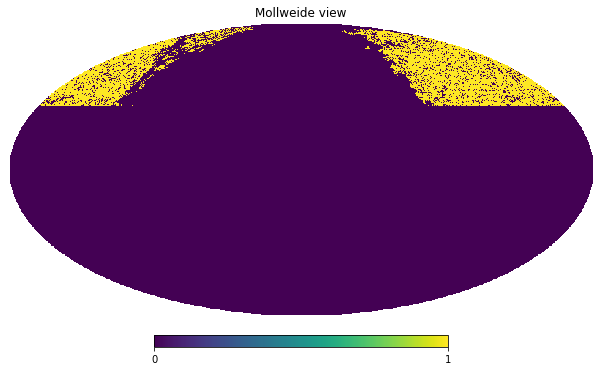

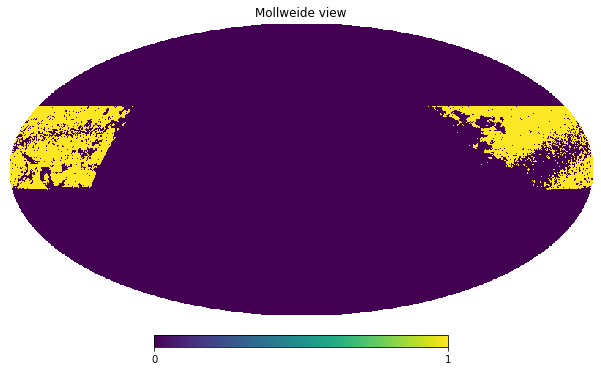

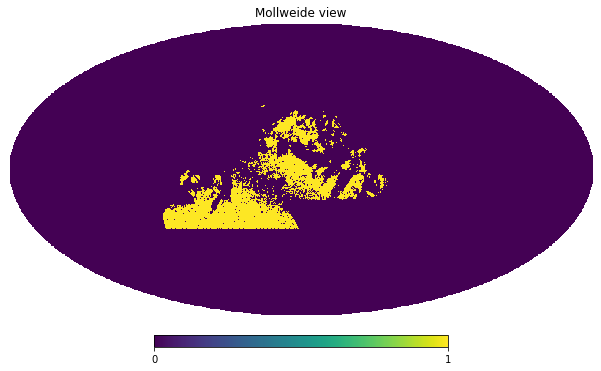

In [12]:
for r in ['bmzls', 'ndecals', 'sdecals']:
    data = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v7/nelg_features_{r}_1024.fits')
    map_ = np.zeros(12*1024*1024)
    map_[data['hpix']] = 1.0
    hp.mollview(map_)

# Prep v7

In [ ]:
import fitsio as ft
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

from astropy.table import Table

lens = ft.read('/fs/ess/PHS0336/data/templates/ebv_lhd.hpx.fits')['EBV']
r = hp.Rotator(coord=['G', 'C'])
dust_lens = r.rotate_map_pixel(lens)

mud15 = np.load('/fs/ess/PHS0336/data/tanveer/Mudur_fw15_NSIDE1024_eq_ELG_mask.npy')
mud6 = np.load('/fs/ess/PHS0336/data/tanveer/Mudur_fw6-1_NSIDE1024_eq_ELG_mask.npy')
sagm = np.load('/fs/ess/PHS0336/data/tanveer/SgrStream_Ramos_NSIDE1024_eq_ELG_mask.npy')
hpix_sag = np.argwhere(sagm > 0.5).flatten()

for r in ['bmzls', 'ndecals', 'sdecals']:

    data = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v6/nelg_features_{r}_1024.fits')
    features = []
    for i, col_i in enumerate(data['features'].T):
        features.append(col_i)
    for col_i in [dust_lens[data['hpix']], mud15[data['hpix']], mud6[data['hpix']]]:
        features.append(col_i)
    features = np.array(features).T

    is_good  = (np.isnan(features).sum(axis=1) == 0) 
    is_good &= ((features == hp.UNSEEN).sum(axis=1)==0)
    is_good &= np.in1d(data['hpix'], hpix_sag)

    meta_data = Table(dict(hpix=data['hpix'][is_good],
                     fracgood=data['fracgood'][is_good],
                     features=features[is_good],
                     label=data['label'][is_good]))

    print(r, len(meta_data)/len(data))
    meta_data.write(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v7/nelg_features_{r}_1024.fits', 
                    format='fits', overwrite=True)

# Prep V4


In [ ]:
def remove_islands(dt, nside=1024):
    # to remove islands in DECaLS N
    
    ra, dec = ut.hpix2radec(nside, dt['hpix'])
    is_good = dec > -11.0 # spurious islands
    
    return dt[is_good]    

"""
ebv_lim = 0.11
galdepth_g_lim = 23.9

#additional lims
galdepth_r_lim = 23.1
galdepth_z_lim = 22.4
psf_g_lim = 2.5
psf_r_lim = 2.5
psf_z_lim = 2.0

"""
for region in ['bmzls', 'ndecals', 'sdecals']:
    
    d = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v4/nelg_features_{region}_1024.fits')

    # EBV < 0.11 and depth-g > 23.9
    is_good = (d['features'][:, 0] < 0.11) 
    is_good &= (d['features'][:, 3] > 23.9)
    is_good &= (d['features'][:, 2] > 23.1)
    is_good &= (d['features'][:, 4] > 22.4)
    is_good &= (d['features'][:, 10] < 2.5)
    is_good &= (d['features'][:, 11] < 2.5)    
    is_good &= (d['features'][:, 12] < 2.0)        
    
    print('{:.1f}% of data in {} is removed'.format((1.-is_good.mean())*100, region))

    dc = d[is_good]
    
    if region=='ndecals':
        dc = remove_islands(dc)
        
    ft.write(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v4/nelg_features_{region}_clean_1024.fits', dc)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import modules as ms
from time import time
from astropy.table import Table
import healpy as hp
import fitsio as ft

import sys
sys.path.insert(0, '/users/PHS0336/medirz90/github/LSSutils')
import lssutils.utils as ut

loader =  ms.DataLoader(maskbits=[1, 12, 13])

for region in ['bmzls', 'ndecals', 'sdecals']:
    
    field = 'north' if region=='bmzls' else 'south'
    print(field, region)
    
    cat = loader.read_cat(field)         # read target catalog
    ran = loader.read_randoms(field)     # read random catalog

    # Gaia and Siena mask
    is_badr0 = np.load(f'is_badr_{field}_siena.npy')
    is_bad0 = np.load(f'is_bad_{field}_siena.npy')
    is_badr1 = np.load(f'is_badr_{field}.npy')
    is_bad1 = np.load(f'is_bad_{field}.npy')

    is_bad = is_bad0 | is_bad1
    is_badr = is_badr0 | is_badr1

    cat = cat[~is_bad]
    ran = ran[~is_badr]
    
    ng = ut.hpixsum(1024, cat['RA'], cat['DEC'])*1.0
    nr = ut.hpixsum(1024, ran['RA'], ran['DEC'])*1.0
    
    dt = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v3/nelg_features_{region}_1024.fits')
    dt['label'][:] = np.nan
    dt['fracgood'][:] = np.nan

    is_good = nr > 0
    ng[~is_good] = np.nan
    nr[~is_good] = np.nan
    
    nr[is_good] = nr[is_good]/(2500*hp.nside2pixarea(1024, degrees=True)*4.0)
    dt['label'] = ng[dt['hpix']]
    dt['fracgood'] = nr[dt['hpix']]    
    
    is_ok = np.ones(dt.size, '?')
    for field in ['label', 'fracgood']:
        is_ok &= np.isfinite(dt[field])
    print(is_ok.mean(), 'after')
    dt_ok = dt[is_ok]
    ft.write(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v4/nelg_features_{region}_1024.fits', dt_ok)

    plt.figure()
    plt.hist(nr, alpha=0.5)
    plt.xlabel('nr')
    plt.show()

In [ ]:
# MCMC
class Chains:
    
    def __init__(self, filename, plot=False):
    
        chains_ = np.load(filename, allow_pickle=True)
        self.chains = chains_['chain']
        self.stats = {'x':chains_['x']}#, 'y':chains_['y']}
        print(self.chains.shape)
        self.ndim = self.chains.shape[-1]

        if plot:
            fg, ax = plt.subplots(nrows=self.ndim, figsize=(8, self.ndim*1), sharex=True)#, sharey=True)
            ax = ax.flatten()
            #ax[0].set_ylim(-.5, .5)

            for i, ix in enumerate(range(self.ndim)): #[0, 1, 2, 3, 5]):
                for j in range(400):
                    ax[i].plot(self.chains[:, j, ix])

                ax[i].axhline(0.0, ls=':')    
            fg.show()
        
    def get_sample(self, skip_rows=400):
        return self.chains[skip_rows:, :, :].reshape(-1, self.ndim)
    
ch1 = Chains('/fs/ess/PHS0336/data/tanveer/dr9/v5/elg_linearp/mcmc_sdecals_1024.npz', False)
ch2 = Chains('/fs/ess/PHS0336/data/tanveer/dr9/v5/elg_linearp/mcmc_ndecals_1024.npz', False)
ch3 = Chains('/fs/ess/PHS0336/data/tanveer/dr9/v5/elg_linearp/mcmc_bmzls_1024.npz', False)

s1 = ch1.get_sample(skip_rows=1000)
s2 = ch2.get_sample(skip_rows=1000)
s3 = ch3.get_sample(skip_rows=1000)

columns = np.array(['c', 'EBV', 'star']\
                  + [f'galdepth-{b}' for b in ['r', 'g', 'z']]\
                  + [f'psfdepth-{b}' for b in ['r', 'g', 'z']]\
                  + [f'psfsize-{b}' for b in ['r', 'g', 'z']]) # 
len(columns)
ix = [0, 1, 4, 9]
from matplotlib.lines import Line2D

l1 = Line2D([], [], color='C2', label='SDECALS', ls='-')
l2 = Line2D([], [], color='C1', label='NDECALS', ls='--')
l3 = Line2D([], [], color='C0', label='BMZLS', ls='-.')


ix = [1, 4, 9]
fg = corner.corner(s1[:, ix], labels=columns[ix], color='C2', group='sdecals')
corner.corner(s2[:, ix], labels=columns[ix], color='C1', fig=fg, group='ndecals')
corner.corner(s3[:, ix], labels=columns[ix], color='C0', fig=fg, group='bmzls', labelpad=0.2)

fg.legend(handles=[l1, l2, l3], bbox_to_anchor=(0., 0.8, 0.8, .0), loc=4)
fg.align_labels()
fg.savefig('mcmc.pdf', bbox_inches='tight')

In [ ]:
# PCC
cc = {}
for r in ['bmzls', 'ndecals', 'sdecals']:
    dt = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v5/nelg_features_{r}_1024.fits')
    cc[r] = pcc(dt['features'], dt['label'], return_err=True)
    
from matplotlib.backends.backend_pdf import PdfPages
pdf = PdfPages('pcc_dr9elg.pdf')

xlabels = ['EBV', 'nstar']\
        + ['galdepth-%s'%s for s in ['r', 'g', 'z']]\
        + ['psfdepth-%s'%s for s in ['r', 'g', 'z', 'w1', 'w2']]\
        + ['psfsize-%s'%s for s in ['r', 'g', 'z']]
xticks = [i for i in range(len(xlabels))]


for ri, cci in cc.items():
    
    fg, ax = plt.subplots()
    
    ax.bar(xticks, cci[0], width=0.5, alpha=0.2)
    ax.fill_between(xticks, *np.percentile(cci[1], [0, 100], axis=0), alpha=0.8, zorder=10,
                    label='Bootstrap')

    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels, rotation=90)
    ax.text(0.7, 0.1, ri.upper(), transform=ax.transAxes)
    ax.grid(True)
    ax.legend()
    ax.set_ylabel('PCC (n$_{g}$, x)')
    
    xyz = np.column_stack([cci[0], *np.percentile(cci[1], [0, 100], axis=0)])
    np.savetxt(f'pcc_dr9_v5_{ri.lower()}.txt', xyz, header='pcc - min pcc - max pcc')
    pdf.savefig(bbox_inches='tight')

pdf.close()


corrm = {}
for r in ['bmzls', 'ndecals', 'sdecals']:
    dt = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v3/nelg_features_{r}_1024.fits')
    corrm[r] = np.corrcoef(dt['features'], rowvar=False)
    
    
pdf = PdfPages('pcc_imaging.pdf')

xlabels = ['EBV', 'nstar']\
        + ['galdepth-%s'%s for s in ['r', 'g', 'z']]\
        + ['psfdepth-%s'%s for s in ['r', 'g', 'z', 'w1', 'w2']]\
        + ['psfsize-%s'%s for s in ['r', 'g', 'z']]
xticks = [i for i in range(len(xlabels))]


for ri, corr_i in corrm.items():
    
    fg, ax = plt.subplots()
    
    map_i = plt.imshow(corr_i, origin='lower', vmin=-1, vmax=1.0, cmap='seismic')
    
    
    ax.set_yticks(xticks)
    ax.set_yticklabels(xlabels)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels, rotation=90)
    fg.colorbar(map_i, label=f'{ri.upper()}  PCC')
    
    pdf.savefig(bbox_inches='tight')

pdf.close()

In [ ]:
ws0 = glob('/fs/ess/PHS0336/data/tanveer/dr9/v5/elg_dnnp/windows/nn*.fits')
ws0 = np.random.permutation(ws0)
len(ws0), ws0[:5]

ws1 = glob('/fs/ess/PHS0336/data/tanveer/dr9/v5/elg_linearp/windows/lin*.fits')
ws1 = np.random.permutation(ws1)
len(ws1), ws1[:5]

d0 = []
d1 = []
kw = dict(verbose=False, dtype=np.float32)

for i in range(3):

    d0.append(hp.read_map(ws0[i], **kw))
    d1.append(hp.read_map(ws1[i], **kw))
    
    print('.', end='')